## Part 0: Setup and Installation

In [ ]:
#@title Step 1:  Mount Google drive, setup project paths, uv and dependancies
import os
from huggingface_hub import HfApi, list_repo_files
from IPython.utils.text import list_strings
from google.colab import files
import pathlib
import shutil
import random
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from google.colab import drive
drive.mount('/content/drive')

PROJECT_ROOT = "/content/drive/MyDrive/Colab Notebooks/MSAAI/AAI_521/Project"
DATA_DIR = os.path.join(PROJECT_ROOT, "data")
MODELS_DIR = os.path.join(PROJECT_ROOT, "models")

os.makedirs(PROJECT_ROOT, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

print("Project Paths:")
print(f" Project Root: {PROJECT_ROOT}")
print(f" Data Directory: {DATA_DIR}")
print(f" Models Directory: {MODELS_DIR}")

!curl -LsSf https://astral.sh/uv/install.sh | sh
os.environ['PATH'] = f"/root/.cargo/bin:{os.environ['PATH']}"
!uv --version
!uv pip install huggingface-hub --system

Mounted at /content/drive
Project Paths:
 Project Root: /content/drive/MyDrive/Colab Notebooks/MSAAI/AAI_521/Project
 Data Directory: /content/drive/MyDrive/Colab Notebooks/MSAAI/AAI_521/Project/data
 Models Directory: /content/drive/MyDrive/Colab Notebooks/MSAAI/AAI_521/Project/models
downloading uv 0.9.16 x86_64-unknown-linux-gnu
no checksums to verify
installing to /usr/local/bin
  uv
  uvx
everything's installed!
uv 0.9.16
Using Python 3.12.12 environment at: /usr
Audited 1 package in 118ms


In [ ]:
#@title Step 2:  Check if Models exist on Hugging Face Hub

REPO_ID = "d2j666/asl-efficientnets"
REQUIRED_FILES = ["efficientnetb4_asl.h5", "efficientnetb7_asl.h5", "efficientnetb9_asl.h5"]
SKIP_TRAINING = False

print("Checking if models exist on Hugging Face Hub...")

try:
  api = HfApi()
  repo = api.repo_info(REPO_ID)
  files = list_repo_files(repo_id=REPO_ID, repo_type="model")

  existing_models = [f for f in REQUIRED_FILES if f in files]
  missing_models = [f for f in REQUIRED_FILES if f not in files]

  if len(existing_models) == len(REQUIRED_FILES):
    print(f" All required models exist on Hugging Face Hub repository {REPO_ID}")

    for model in existing_models:
      try:
          print(f"   Model {model} found.")
      except:
          print(f"   Model {model} not found.")

    SKIP_TRAINING = True

  elif len(existing_models) < len(REQUIRED_FILES):
    print(f"  Some models exist on Hugging Face Hub repository {REPO_ID}, but not all required models.")
    print(f"   Existing models: {existing_models}")
    print(f"   Missing models: {missing_models}")
    SKIP_TRAINING = False

except Exception as e:
    error_msg = str(e).lower()
    SKIP_TRAINING = False

print(f"\n Skip Training? {SKIP_TRAINING}")

Checking if models exist on Hugging Face Hub...
 All required models exist on Hugging Face Hub repository d2j666/asl-efficientnets
   Model efficientnetb4_asl.h5 found.
   Model efficientnetb7_asl.h5 found.
   Model efficientnetb9_asl.h5 found.

 Skip Training? True


In [ ]:
#@title Step 2:  Check GPU Availability

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB4, EfficientNetB7, EfficientNetV2L
from tensorflow.keras import models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

print("TensorFlow version:", tf.__version__)
print("GPUs available:", tf.config.list_physical_devices('GPU'))

if len(tf.config.list_physical_devices('GPU')) == 0:
  raise Exception("Go to Runtime → Change runtime type → Select GPU (A100 if available)")

TensorFlow version: 2.19.0
GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
#@title Step 3: Download Kaggle dataset directly to Colab
from google.colab import files

# Check if kaggle.json already exists
kaggle_dir = pathlib.Path.home() / ".kaggle"
kaggle_json_path = kaggle_dir / "kaggle.json"

if not kaggle_json_path.exists():
  print("   Please upload your kaggle.json file:\n")
  uploaded = files.upload()

  if "kaggle.json" not in uploaded:
    raise Exception("  Could not upload kaggle.json")
  else:
    kaggle_dir.mkdir(exist_ok=True)
    shutil.move("kaggle.json", kaggle_json_path)
    os.chmod(kaggle_json_path, 0o600)

print("\n  Testing Kaggle API connection...")
!kaggle datasets list -s "asl alphabet" | head -3

# Define paths
LOCAL_DATA_PATH = "/content/asl_alphabet"
TRAIN_DATA_PATH = os.path.join(LOCAL_DATA_PATH, "asl_alphabet_train", "asl_alphabet_train")
TEST_DATA_PATH = os.path.join(LOCAL_DATA_PATH, "asl_alphabet_test", "asl_alphabet_test")

# Download data directly to Colab local storage (fastest option)
if os.path.exists(TRAIN_DATA_PATH) and len(os.listdir(TRAIN_DATA_PATH)) == 29:
  print(f"\n Dataset already in Colab local storage")
  print(f"   Classes found: {len(os.listdir(TRAIN_DATA_PATH))}")
else:
  print("\n Downloading ASL dataset from Kaggle to Colab...")
  print("    Size: ~1.1 GB | Extracting directly to local storage")
  !kaggle datasets download -d grassknoted/asl-alphabet -p {LOCAL_DATA_PATH} --unzip
  print("\n Dataset downloaded and extracted!")

print(f"\n Dataset Ready:")
print(f"    Train path: {TRAIN_DATA_PATH}")
print(f"    Test path: {TEST_DATA_PATH}")
print(f"    Classes: {os.listdir(TRAIN_DATA_PATH)[:10]} ... (29 total)")

   Please upload your kaggle.json file:



Saving kaggle.json to kaggle.json

  Testing Kaggle API connection...
ref                                                          title                                                    size  lastUpdated                 downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  ------------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
grassknoted/asl-alphabet                                     ASL Alphabet                                       1100887034  2018-04-22 19:31:36.210000         107932       1200  0.875            

    Size: ~1.1 GB | Extracting directly to local storage
Dataset URL: https://www.kaggle.com/datasets/grassknoted/asl-alphabet
License(s): GPL-2.0
 94% 988M/1.03G [00:00<00:00, 1.71GB/s]
100% 1.03G/1.03G [00:00<00:00, 1.71GB/s]

 Dataset downloaded and extracted!

 Dataset Ready:
    Train path: /content/asl_alphabet/asl_alphabet_train/asl

## Part 1:  Pipeline Setup, Model Building, Training & Testing

In [ ]:
#@title Step 1:  Setup Data Generators
# Configuration
IMG_SIZE = (224, 224)
BATCH_SIZE = 64  # Use 32 if GPU memory limited
NUM_CLASSES = 29
AUTOTUNE = tf.data.AUTOTUNE

# Create datasets using modern API
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  TRAIN_DATA_PATH,
  label_mode="categorical",
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE,
  validation_split=0.2,
  subset="training",
  seed=42
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  TRAIN_DATA_PATH,
  label_mode="categorical",
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE,
  validation_split=0.2,
  subset="validation",
  seed=42
)

class_names = train_ds.class_names

# Performance optimizations
train_ds = train_ds.shuffle(1000).prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

# Augmentation
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.05),      # ~18 degrees
  layers.RandomZoom(0.1),
  layers.RandomTranslation(0.1, 0.1),
])

print(f"\n Data pipeline ready!")
print(f"  Training batches: {len(train_ds)}")
print(f"  Validation batches: {len(val_ds)}")
print(f"  Classes: {class_names[:5]} ... ({NUM_CLASSES} total)")

Found 87000 files belonging to 29 classes.
Using 69600 files for training.
Found 87000 files belonging to 29 classes.
Using 17400 files for validation.

 Data pipeline ready!
  Training batches: 1088
  Validation batches: 272
  Classes: ['A', 'B', 'C', 'D', 'E'] ... (29 total)


In [ ]:
#@title Step 1a: Optional callbacks

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

print("   Available: EarlyStopping, ReduceLROnPlateau, ModelCheckpoint")
print("   Note: Not used by default, but ready if you want to add them")

   Available: EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
   Note: Not used by default, but ready if you want to add them


In [ ]:
#@title Step 2:  Build EfficientNet Model
def build_efficientnet_model(model_name="B4", num_classes=29):
  """
  Build EfficientNet model with 2-stage training capability.

  Args:
      model_name: "B4", "B7", or "B9"
      num_classes: Number of output classes (29 for ASL)

  Returns:
      Tuple of (model, base_model) ready for 2-stage training
  """

  print(f"Building EfficientNet{model_name} model...")

  # Load pre-trained base model
  if model_name == "B4":
      base_model = EfficientNetB4(
        include_top=False,
        weights="imagenet",
        input_shape=IMG_SIZE + (3,)
      )
  elif model_name == "B7":
      base_model = EfficientNetB7(
        include_top=False,
        weights="imagenet",
        input_shape=IMG_SIZE + (3,)
      )
  elif model_name == "B9":
      base_model = EfficientNetV2L(
        include_top=False,
        weights="imagenet",
        input_shape=IMG_SIZE + (3,)
      )
  else:
      raise ValueError(f"Unknown model name: {model_name}")

  # Build model with augmentation
  inputs = layers.Input(shape=IMG_SIZE + (3,))
  x = data_augmentation(inputs)
  x = tf.keras.applications.efficientnet.preprocess_input(x)
  x = base_model(x, training=False)
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dropout(0.3)(x)
  outputs = layers.Dense(num_classes, activation="softmax")(x)

  model = models.Model(inputs, outputs)

  print(f"\n Model built successfully!")
  print(f"   Total parameters: {model.count_params():,}")

  return model, base_model

In [ ]:
#@title Step 3: Override SKIP_TRAINING (Optional - Set to False to force training)
# Uncomment the line below to force training even if models exist
SKIP_TRAINING = False

print(f" Skip Training? {SKIP_TRAINING}")
if SKIP_TRAINING:
  print("    To force retraining, uncomment the line above")

 Skip Training? False


In [ ]:
#@title Step 3a: Train EfficientNetB4 (2-Stage Fine-Tuning)
# Stage 1: Freeze backbone, train head (5 epochs)
# Stage 2: Fine-tune top layers (5 epochs)

if SKIP_TRAINING:
  print("\n Models already exist in HuggingFace Hub")
else:
  print("Stage 1: WARM-UP")

  # Build model
  model_b4, base_b4 = build_efficientnet_model("B4", num_classes=NUM_CLASSES)

  # Stage 1: Freeze backbone, train classification head
  base_b4.trainable = False

  model_b4.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
  )

  # Train Stage 1
  history_b4_stage1 = model_b4.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
  )

  print(f"\n Stage 1 complete! Val accuracy: {history_b4_stage1.history['val_accuracy'][-1]:.4f}")

  # Stage 2: Fine-tune top layers
  print("\n" + "="*60)
  print("Training EfficientNetB4 - Stage 2: FINE-TUNING")
  print("="*60 + "\n")

  base_b4.trainable = True

  # Freeze lower layers, train top ~150 layers
  for layer in base_b4.layers[:-150]:
      layer.trainable = False

  model_b4.compile(
      optimizer=tf.keras.optimizers.Adam(1e-5),  # Lower learning rate!
      loss="categorical_crossentropy",
      metrics=["accuracy"]
  )

  # Train Stage 2
  history_b4_stage2 = model_b4.fit(
      train_ds,
      validation_data=val_ds,
      epochs=5
  )

  # Save model
  b4_save_path = os.path.join(MODELS_DIR, 'efficientnetb4_asl.h5')
  model_b4.save(b4_save_path)

  best_val_acc = max(history_b4_stage2.history['val_accuracy'])
  print(f"\n EfficientNetB4 training complete!")
  print(f"   Saved to: {b4_save_path}")
  print(f"   Best validation accuracy: {best_val_acc:.4f}")

Stage 1: WARM-UP
Building EfficientNetB4 model...
71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

 Model built successfully!
   Total parameters: 17,725,820
Epoch 1/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 156s 88ms/step - accuracy: 0.5312 - loss: 1.8224 - val_accuracy: 0.8880 - val_loss: 0.4797
Epoch 2/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 99s 82ms/step - accuracy: 0.8036 - loss: 0.7351 - val_accuracy: 0.9144 - val_loss: 0.3316
Epoch 3/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 98s 82ms/step - accuracy: 0.8302 - loss: 0.5956 - val_accuracy: 0.9289 - val_loss: 0.2669
Epoch 4/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 98s 82ms/step - accuracy: 0.8416 - loss: 0.5333 - val_accuracy: 0.9340 - val_loss: 0.2360
Epoch 5/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 98s 82ms/step - accuracy: 0.8502 - loss: 0.4906 - val_accuracy: 0.9451 - val_loss: 0.2002

 Stage 1 complete! Val accuracy: 0.9451

Training EfficientNetB4 - Stage 2: FINE-TUNING

Epoch 1/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 189s 130ms/step - accuracy: 0.7341 - loss: 0.9172 - 


 EfficientNetB4 training complete!
   Saved to: /content/drive/MyDrive/Colab Notebooks/MSAAI/AAI_521/Project/models/efficientnetb4_asl.h5
   Best validation accuracy: 0.9994


In [ ]:
#@title Step 3b: Train EfficientNetB7 (2-Stage Fine-Tuning)
# Stage 1: Freeze backbone, train head (5 epochs)
# Stage 2: Fine-tune top layers (5 epochs)

if SKIP_TRAINING:
  print("\n Models already exist in HuggingFace Hub")
else:
  print("Stage 1: WARM-UP")


  # Build model
  model_b7, base_b7 = build_efficientnet_model("B7", num_classes=NUM_CLASSES)

  # Stage 1: Freeze backbone, train classification head
  base_b7.trainable = False

  model_b7.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
  )

  # Train Stage 1
  history_b7_stage1 = model_b7.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
  )

  print(f"\n Stage 1 complete! Val accuracy: {history_b7_stage1.history['val_accuracy'][-1]:.4f}")

  # Stage 2: Fine-tune top layers
  print("\n" + "="*60)
  print("Training EfficientNetB7 - Stage 2: FINE-TUNING")
  print("="*60 + "\n")

  base_b7.trainable = True

  # Freeze lower layers, train top ~150 layers
  for layer in base_b7.layers[:-150]:
      layer.trainable = False

  model_b7.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Lower learning rate!
    loss="categorical_crossentropy",
    metrics=["accuracy"]
  )

  # Train Stage 2
  history_b7_stage2 = model_b7.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
  )

  # Save model
  b7_save_path = os.path.join(MODELS_DIR, 'efficientnetb7_asl.h5')
  model_b7.save(b7_save_path)

  best_val_acc = max(history_b7_stage2.history['val_accuracy'])
  print(f"\n EfficientNetB7 training complete!")
  print(f"   Saved to: {b7_save_path}")
  print(f"   Best validation accuracy: {best_val_acc:.4f}")

Stage 1: WARM-UP
Building EfficientNetB7 model...
258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

 Model built successfully!
   Total parameters: 64,171,956
Epoch 1/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 241s 182ms/step - accuracy: 0.6121 - loss: 1.5484 - val_accuracy: 0.9061 - val_loss: 0.3593
Epoch 2/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 196s 172ms/step - accuracy: 0.8564 - loss: 0.5506 - val_accuracy: 0.9359 - val_loss: 0.2345
Epoch 3/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 196s 172ms/step - accuracy: 0.8783 - loss: 0.4270 - val_accuracy: 0.9359 - val_loss: 0.2104
Epoch 4/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 197s 173ms/step - accuracy: 0.8895 - loss: 0.3791 - val_accuracy: 0.9504 - val_loss: 0.1719
Epoch 5/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 197s 173ms/step - accuracy: 0.9005 - loss: 0.3361 - val_accuracy: 0.9485 - val_loss: 0.1594

 Stage 1 complete! Val accuracy: 0.9485

Training EfficientNetB7 - Stage 2: FINE-TUNING

Epoch 1/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 318s 236ms/step - accuracy: 0.8458 - loss


 EfficientNetB7 training complete!
   Saved to: /content/drive/MyDrive/Colab Notebooks/MSAAI/AAI_521/Project/models/efficientnetb7_asl.h5
   Best validation accuracy: 0.9996


In [ ]:
#@title Step 3c: Train EfficientNetB9 (2-Stage Fine-Tuning)
# Stage 1: Freeze backbone, train head (5 epochs)
# Stage 2: Fine-tune top layers (5 epochs)

if SKIP_TRAINING:
  print("\n Models already exist in HuggingFace Hub")
else:
  print("Training EfficientNetB9 - STAGE 1: WARM-UP")

  # Build model
  model_b9, base_b9 = build_efficientnet_model("B9", num_classes=NUM_CLASSES)

  # Stage 1: Freeze backbone, train classification head
  base_b9.trainable = False

  model_b9.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
  )

  # Train Stage 1
  history_b9_stage1 = model_b9.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
  )

  print(f"\n Stage 1 complete! Val accuracy: {history_b9_stage1.history['val_accuracy'][-1]:.4f}")

  # Stage 2: Fine-tune top layers
  print("Training EfficientNetB9 - Stage 2: FINE-TUNING")

  base_b9.trainable = True

  # Freeze lower layers, train top ~150 layers
  for layer in base_b9.layers[:-150]:
      layer.trainable = False

  model_b9.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Lower learning rate!
    loss="categorical_crossentropy",
    metrics=["accuracy"]
  )

  # Train Stage 2
  history_b9_stage2 = model_b9.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
  )

  # Save model
  b9_save_path = os.path.join(MODELS_DIR, 'efficientnetb9_asl.h5')
  model_b9.save(b9_save_path)

  best_val_acc = max(history_b9_stage2.history['val_accuracy'])
  print(f"\n EfficientNetB9 training complete!")
  print(f"   Saved to: {b9_save_path}")
  print(f"   Best validation accuracy: {best_val_acc:.4f}")

Training EfficientNetB9 - STAGE 1: WARM-UP
Building EfficientNetB9 model...
473176280/473176280 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step

 Model built successfully!
   Total parameters: 117,783,997
Epoch 1/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 232s 164ms/step - accuracy: 0.4548 - loss: 2.0349 - val_accuracy: 0.8783 - val_loss: 0.5761
Epoch 2/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 174s 152ms/step - accuracy: 0.7188 - loss: 0.9946 - val_accuracy: 0.9050 - val_loss: 0.3987
Epoch 3/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 174s 152ms/step - accuracy: 0.7525 - loss: 0.8287 - val_accuracy: 0.9203 - val_loss: 0.3228
Epoch 4/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 174s 152ms/step - accuracy: 0.7740 - loss: 0.7466 - val_accuracy: 0.9255 - val_loss: 0.2791
Epoch 5/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 174s 151ms/step - accuracy: 0.7821 - loss: 0.7068 - val_accuracy: 0.9339 - val_loss: 0.2479

 Stage 1 complete! Val accuracy: 0.9339
Training EfficientNetB9 - Stage 2: FINE-TUNING
Epoch 1/5
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 313s 222ms/step


 EfficientNetB9 training complete!
   Saved to: /content/drive/MyDrive/Colab Notebooks/MSAAI/AAI_521/Project/models/efficientnetb9_asl.h5
   Best validation accuracy: 0.9999


Model Comparison Summary (2-STAGE TRAINING)

         Model Stage 1 Val Acc Final Val Acc Best Val Acc
EfficientNetB4          0.9451        0.9994       0.9994
EfficientNetB7          0.9485        0.9996       0.9996
EfficientNetB9          0.9339        0.9999       0.9999

 Comparison chart saved to: /content/drive/MyDrive/Colab Notebooks/MSAAI/AAI_521/Project/models/training_comparison.png


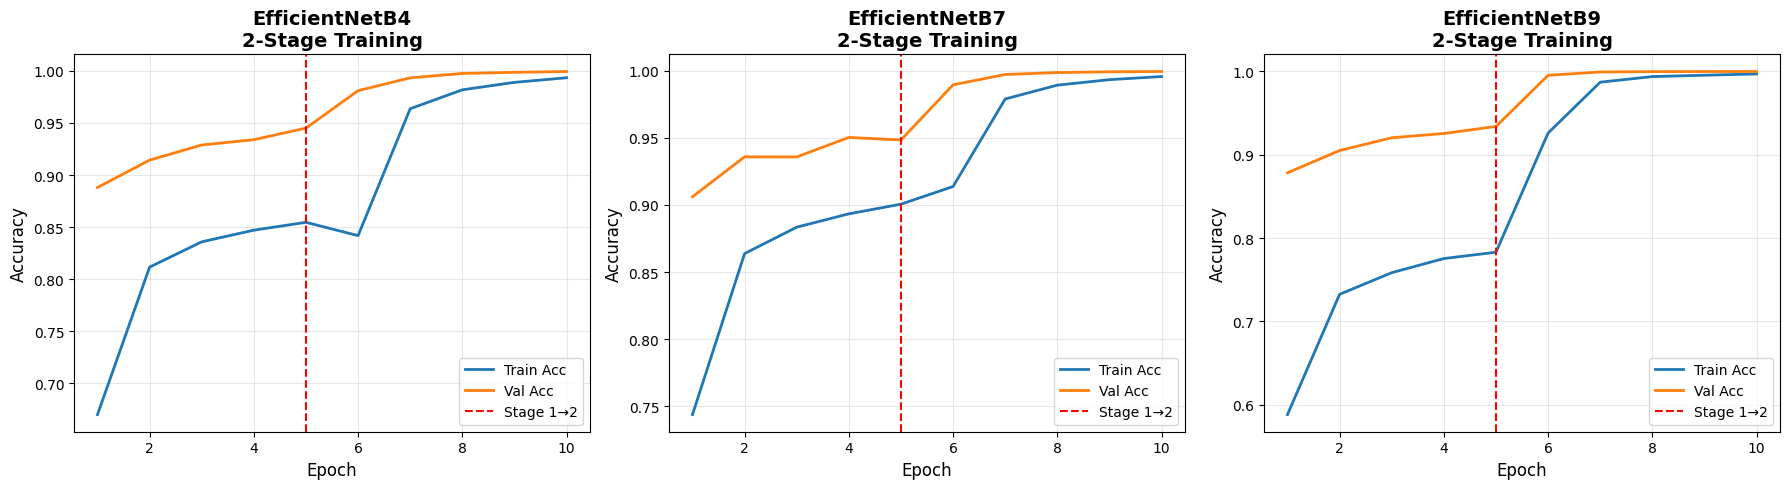

In [ ]:
#@title Step 4: Training Results Comparison

if SKIP_TRAINING:
  print("\n No training occurred (models already exist)")
  print("   Models are available on HuggingFace Hub")
else:
  import matplotlib.pyplot as plt
  import pandas as pd

  def combine_histories(h1, h2):
    combined = {}
    for key in h1.history.keys():
      combined[key] = h1.history[key] + h2.history[key]
    return combined

  history_b4_full = combine_histories(history_b4_stage1, history_b4_stage2)
  history_b7_full = combine_histories(history_b7_stage1, history_b7_stage2)
  history_b9_full = combine_histories(history_b9_stage1, history_b9_stage2)

  results = {
      "Model": ["EfficientNetB4", "EfficientNetB7", "EfficientNetB9"],
      "Stage 1 Val Acc": [
          f"{history_b4_stage1.history['val_accuracy'][-1]:.4f}",
          f"{history_b7_stage1.history['val_accuracy'][-1]:.4f}",
          f"{history_b9_stage1.history['val_accuracy'][-1]:.4f}"
      ],
      "Final Val Acc": [
          f"{history_b4_full['val_accuracy'][-1]:.4f}",
          f"{history_b7_full['val_accuracy'][-1]:.4f}",
          f"{history_b9_full['val_accuracy'][-1]:.4f}"
      ],
      "Best Val Acc": [
          f"{max(history_b4_full['val_accuracy']):.4f}",
          f"{max(history_b7_full['val_accuracy']):.4f}",
          f"{max(history_b9_full['val_accuracy']):.4f}"
      ]
  }

  df_results = pd.DataFrame(results)
  print("Model Comparison Summary (2-STAGE TRAINING)\n")
  print(df_results.to_string(index=False))

  # Plot training curves
  fig, axes = plt.subplots(1, 3, figsize=(18, 5))

  for idx, (history, name) in enumerate([
    (history_b4_full, "EfficientNetB4"),
    (history_b7_full, "EfficientNetB7"),
    (history_b9_full, "EfficientNetB9")
  ]):
    ax = axes[idx]
    epochs = range(1, len(history['accuracy']) + 1)
    ax.plot(epochs, history['accuracy'], label='Train Acc', linewidth=2)
    ax.plot(epochs, history['val_accuracy'], label='Val Acc', linewidth=2)
    ax.axvline(x=5, color='red', linestyle='--', label='Stage 1→2')
    ax.set_title(f"{name}\n2-Stage Training", fontsize=14, fontweight='bold')
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)

  plt.tight_layout()
  chart_path = os.path.join(MODELS_DIR, 'training_comparison.png')
  plt.savefig(chart_path, dpi=150, bbox_inches='tight')
  print(f"\n Comparison chart saved to: {chart_path}")
  plt.show()

Testing Model Predictions
Test 1: True label = 'M'
------------------------------------------------------------
EfficientNetB4       → M          (confidence: 1.000)
EfficientNetB7       → M          (confidence: 1.000)
EfficientNetB9       → M          (confidence: 1.000)

Sample image:


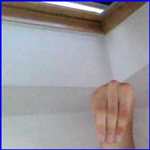



Test 2: True label = 'X'
------------------------------------------------------------
EfficientNetB4       → X          (confidence: 1.000)
EfficientNetB7       → X          (confidence: 1.000)
EfficientNetB9       → X          (confidence: 1.000)

Sample image:


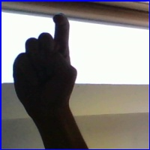



Test 3: True label = 'F'
------------------------------------------------------------
EfficientNetB4       → F          (confidence: 0.998)
EfficientNetB7       → F          (confidence: 1.000)
EfficientNetB9       → F          (confidence: 1.000)

Sample image:


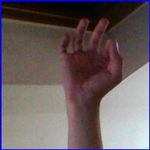

In [ ]:
#@title Step 5: Test Models with Sample Predictions

if SKIP_TRAINING:
  print(" To test predictions:")
  print("   1. Set SKIP_TRAINING = False and run training cells, OR")
  print("   2. Load models from Drive/HuggingFace Hub first")
else:
  def test_prediction(model, img_path, model_name):
      """Test a single image prediction."""
      img = image.load_img(img_path, target_size=(224, 224))
      img_array = image.img_to_array(img)
      img_array = preprocess_input(img_array)
      img_array = np.expand_dims(img_array, axis=0)

      preds = model.predict(img_array, verbose=0)[0]
      top_idx = np.argmax(preds)

      print(f"{model_name:20} → {class_names[top_idx]:10} (confidence: {preds[top_idx]:.3f})")

  print("Testing Model Predictions")

  for test_num in range(3):
      test_class = random.choice(class_names)
      test_class_dir = os.path.join(TRAIN_DATA_PATH, test_class)
      test_img = random.choice(os.listdir(test_class_dir))
      test_img_path = os.path.join(test_class_dir, test_img)

      print(f"Test {test_num + 1}: True label = '{test_class}'")
      print("-" * 60)

      test_prediction(model_b4, test_img_path, "EfficientNetB4")
      test_prediction(model_b7, test_img_path, "EfficientNetB7")
      test_prediction(model_b9, test_img_path, "EfficientNetB9")

      print("\nSample image:")
      display(Image.open(test_img_path).resize((150, 150)))
      print("\n" + "="*60 + "\n")

In [ ]:
#@title Step 6: Upload Models to HuggingFace Hub

if SKIP_TRAINING:
  print("\n  No models to upload (training was skipped)")
  print(f"    Models already exist at: https://huggingface.co/{REPO_ID}")
else:
  print("\n Please ensure your HuggingFace token is set as a Colab secret (HF_TOKEN)")
  print("    Get it from: https://huggingface.co/settings/tokens (type: Write)\n")

  api = HfApi()
  REPO_ID = "d2j666/asl-efficientnets"

  try:
      api.create_repo(repo_id=REPO_ID, exist_ok=True, private=True)
      print(f" Repository '{REPO_ID}' created or already exists.")
  except Exception as e:
      print(f" An error occurred: {e}")

  print(f"\n Uploading models to: {REPO_ID}\n")

  model_files = [
      (os.path.join(MODELS_DIR, 'efficientnetb4_asl.h5'), 'efficientnetb4_asl.h5'),
      (os.path.join(MODELS_DIR, 'efficientnetb7_asl.h5'), 'efficientnetb7_asl.h5'),
      (os.path.join(MODELS_DIR, 'efficientnetb9_asl.h5'), 'efficientnetb9_asl.h5')
  ]

  upload_count = 0
  for local_path, repo_path in model_files:
      if os.path.exists(local_path):
          file_size_mb = os.path.getsize(local_path) / (1024 * 1024)
          print(f" Uploading {repo_path} ({file_size_mb:.1f} MB)...")

          try:
              api.upload_file(
                  path_or_fileobj=local_path,
                  path_in_repo=repo_path,
                  repo_id=REPO_ID,
                  repo_type="model"
              )
              print(f"    {repo_path} uploaded!\n")
              upload_count += 1
          except Exception as e:
              print(f"    Error: {e}\n")
      else:
          print(f"  {repo_path} not found at {local_path}\n")

  if upload_count == len(model_files):
      print(" Models uploaded.")
  else:
      print(f"  Partial Upload ({upload_count}/{len(model_files)} successful)")
  print(f"\n View at: https://huggingface.co/{REPO_ID}")


 Please ensure your HuggingFace token is set as a Colab secret (HF_TOKEN)
    Get it from: https://huggingface.co/settings/tokens (type: Write)

 Repository 'd2j666/asl-efficientnets' created or already exists.

 Uploading models to: d2j666/asl-efficientnets

 Uploading efficientnetb4_asl.h5 (175.1 MB)...


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...els/efficientnetb4_asl.h5:   0%|          |  393kB /  184MB            

    efficientnetb4_asl.h5 uploaded!

 Uploading efficientnetb7_asl.h5 (520.7 MB)...


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...els/efficientnetb7_asl.h5:   0%|          |  643kB /  546MB            

    efficientnetb7_asl.h5 uploaded!

 Uploading efficientnetb9_asl.h5 (807.9 MB)...


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...els/efficientnetb9_asl.h5:   0%|          |  839kB /  847MB            

    efficientnetb9_asl.h5 uploaded!

 Models uploaded.

 View at: https://huggingface.co/d2j666/asl-efficientnets
